In [31]:
# Score all words
import sys; sys.path.append('../..')
from abslithist import *

In [32]:
def get_scores_text(path_json):
    if not path_json or not os.path.exists(path_json): return {}
    norms = get_allnorms()
    with open(path_json,'rb') as f: jsons = f.read()
    freqd = orjson.loads(jsons)
    freqs = pd.Series(freqd)
    freqs/=sum(freqs)
    shared = set(freqs.index) & set(norms.index)
    odf = norms.loc[shared].multiply(freqs[shared],axis=0)
    odfs = odf.mean()
    return dict(odfs)

In [33]:
def do_get_scores_year(path_json,okwords=None, modd={}):
    if not path_json or not os.path.exists(path_json): return []
    with open(path_json,'rb') as f: jsons = f.read()
    fd = orjson.loads(jsons)
    l=[]
    for word,count in fd.items():
        word=modd.get(word,word).lower()
        if word in okwords and len(word)>=3:
            for i in range(count):
                l.append(word)
    return l

def get_scores_year(paths_json, num_samples=10, sample_len=10000, return_full=False):
    norms = get_allnorms()
    normwords = set(norms.index)
    stops = get_stopwords() | {'thou','thee','thy',"o'er"}
    words = get_wordlist()

    okwords = (words&normwords) - stops
    modd = get_spelling_modernizer()
    freqd=Counter()
    l=[]
    for resl in pmap_iter(
            do_get_scores_year,
            paths_json,
            kwargs=dict(okwords=okwords, modd=modd),
            num_proc=1,
            progress=False):
        l.extend(resl)
    
    ol=[]
    if len(l)<1000: return pd.DataFrame()
    for run in tqdm(list(range(num_samples)), disable=True):
        smpl = random.choices(l, k=sample_len)
        freqd = Counter(smpl)
        freqs=pd.Series(freqd)
        num_words=sum(freqs)
        #freqs/=num_words
        #freqs*=sample_len
        # display(freqs.sort_values())
        shared = set(freqs.index) & set(norms.index)
        odf = norms.loc[shared].multiply(freqs[shared],axis=0)
        # display(odf.sort_values('Abs-Conc.Median.median'))
        if return_full:
            ol.append(odf)
        else:
            odfs = odf.mean()
            # display(odfs.sort_values())
            odfd=dict(odfs)
            odfd['num_words']=len(l)
            odfd['num_words_smpl']=len(smpl)
            odfd['num_texts']=len(paths_json)
            odfd['words']=', '.join(smpl[:10])
            ol.append(odfd)
    return pd.DataFrame(ol) if not return_full else pd.concat(ol)

In [34]:
def get_egs(cent1=1600,cent2=1900,ncut=10,only_extremes=True):
    C=lltk.load('CanonFiction')
    paths_json1 = [t.path_freqs for t in C.texts() if t.century==1600]
    paths_json2 = [t.path_freqs for t in C.texts() if t.century==1900]
    # paths_json1=random.sample(paths_json1,100)
    # paths_json2=random.sample(paths_json2,100)
    eg1=get_scores_year(paths_json1, return_full=True).groupby('word').mean()['Abs-Conc.Median.C17'].sort_values().dropna()
    eg2=get_scores_year(paths_json2, return_full=True).groupby('word').mean()['Abs-Conc.Median.C20'].sort_values().dropna()
    eg1df=pd.DataFrame({'absconc':eg1})
    eg1df['qcut']=(pd.qcut(eg1,ncut,labels=False) + 1)
    eg2df=pd.DataFrame({'absconc':eg2})
    eg2df['qcut']=(pd.qcut(eg2,ncut,labels=False) + 1)
    egdf = pd.concat([eg1df.assign(period='C16'),eg2df.assign(period='C20')])
    # egdf
    o=[]
    for p,pdf in egdf.groupby('period'):
        for q,qdf in pdf.groupby('qcut'):
            qwords=', '.join(qdf.sample(n=5).index)
            odx=dict(period=p, quantile=q, words=qwords)
            o.append(odx)
    wdf=pd.DataFrame(o)
    wdf=wdf.pivot('quantile','period','words')
    printm(wdf.to_markdown())

In [35]:
# get_egs(ncut=5)

In [36]:
def get_egs_simple(key='Abs-Conc.Median.median',n=25):
    C=lltk.load('CanonFiction')
    norms = get_allnorms()[[key]].reset_index().dropna().sort_values(key)
    wrds=set(C.mfw(2000,only_pos={'n*','j*'},excl_stopwords=True))
    norms = norms[norms.word.isin(wrds)]

    def tocat(x):
        if x>1: return 'Concrete'
        if x<-1: return 'Abstract'
        if abs(x)<0.25: return 'Ambiguous'
        return ''
    
    norms['cat']=norms[key].apply(tocat)


    for cat in ['Concrete','Abstract']:
        cdf=norms[norms.cat==cat]
        cwords=cdf.sample(n=n)
        print(f'{cat}: {", ".join(cwords.word)}...')
        print()


In [37]:
get_egs_simple()

Concrete: bridge, surface, rope, carriage, woods, giant, purple, water, sheep, grey, neat, shore, desk, winter, deck, tree, sand, birds, sweat, corner, sunlight, pair, bed, guns, dirty...

Abstract: motives, conditions, affections, vanity, readers, claim, absence, grant, nation, indignation, enthusiasm, power, answer, promises, history, absolute, instance, principles, writer, effects, action, shocked, rule, enemies, assembly...



In [38]:
def do_get_scores_corpus(obj):
    paths_json=obj[1]
    odx = get_scores_year(paths_json)
    odx['year'],odx['genre'] = obj[0]
    odx['year']=odx['year'].apply(int)
    return odx

def get_scores_corpus(C, lim=None, num_proc=1, force=False, year_min=1580, year_max=2022):
    C = lltk.load(C) if type(C)==str else C
    ofn = os.path.join(PATH_SCORES, f'data.scores.{C.name}.v2.pkl')
    if not force and os.path.exists(ofn): return read_df(ofn)

    meta=C.meta[~C.meta.year.isna()]
    meta['year']=meta.year.apply(lambda x: int(x))
    meta=meta[meta.year>=year_min]
    meta=meta[meta.year<=year_max]
    y2paths=[
        ((year,genre),list(ydf.path_freqs))
        for (year,genre),ydf in meta.groupby(['year','genre'])
    ]# if year==1800]
    random.shuffle(y2paths)
    objs = y2paths[:lim]
    
    oiterr = pmap_iter(do_get_scores_corpus, objs, num_proc=num_proc)
    odf = pd.concat(oiterr).set_index(['genre','year']).sort_values('Abs-Conc.Median.median')
    save_df(odf, ofn)
    return odf
    

### Creation

In [39]:
# # CanonFiction
df=get_scores_corpus('CanonFiction').reset_index().sort_values('year')

In [40]:
# Hathi
df=get_scores_corpus('HathiEngLit')
df=get_scores_corpus('HathiBio')
df=get_scores_corpus('HathiEssays')
df=get_scores_corpus('HathiSermons')
df=get_scores_corpus('HathiTreatises')
# df

In [41]:
# ChadwyckPoetry
df=get_scores_corpus('ChadwyckPoetry')
# df

In [42]:
# bpo = lltk.load('BPO')
# bpo._metadf['genre']=bpo._metadf.genre.fillna('')
# bpo._metadf=bpo._metadf[~bpo._metadf.genre.isin({'Fiction','Poem','Advertisement','Recipe','Front Matter','Back Matter','Undefined'})]
# bpo._metadf['genre']='Periodical'
# df=get_scores_corpus(bpo)
# # df

In [43]:
# # COHA
# coha = lltk.load('COHA',force=True)
# coha._metadf = coha._metadf[coha._metadf.genre.isin({'Magazine','Non-Fiction'})]
# coha._metadf['genre'] = coha._metadf['genre'].apply(lambda x: x if x=="Non-Fiction" else "Periodical")
# coha.meta.genre.value_counts()
# df=get_scores_corpus(coha).reset_index()
# df.genre.value_counts()

In [44]:
# from lltk.corpus.ecco_tcp import fix_genre
# eebo=lltk.load('EEBO_TCP')
# meta=eebo.meta
# # meta=meta[meta.genre=="Prose"]
# meta['genre']=[fix_genre(g,t) for g,t in zip(meta.genre, meta.title)]
# meta.genre.value_counts()
# eebo._metadf=meta
# df=get_scores_corpus(eebo)

In [45]:
# from lltk.corpus.ecco_tcp import fix_genre
# ecco=lltk.load('ECCO_TCP')
# meta=ecco.meta
# meta['genre']='Unknown'
# meta['genre']=[fix_genre(g,t) for g,t in zip(meta.genre, meta.title)]
# meta=meta[meta.genre!='Unknown']
# meta.genre.value_counts()
# ecco._metadf=meta
# df=get_scores_corpus(ecco).reset_index()
# # df[df.genre=='Sermon'].year.value_counts()

## Plotting

In [46]:
corps = [
    'CanonFiction',
    # 'BPO',
    # 'HathiEngLit',
    # 'COHA',
    'EEBO_TCP',
    # 'ECCO_TCP',
    'HathiEssays',
    'HathiSermons',
    'ChadwyckPoetry',
    # 'HathiBio',
    'HathiTreatises'
]
genred=dict(Verse='Poetry')

In [47]:
badgenres={
    'Drama',
    'Government',
    'Letters',
    'Prose',
    'Sermon',
    'Treatise'
}

o=[]
for corp in tqdm(corps):
    C=lltk.load(corp)
    df = get_scores_corpus(corp).reset_index().drop('words',1)
    df=df[~df.year.isna()]
    df=df.query('1580<=year<=2022')

    if corp.startswith('Hathi'):
        df=df.query('1700<=year<2010')
    elif corp=='HathiEngLit':
        df=df[df.genre=='Fiction']
        df=df[df.year>=1800]
    elif corp=='BPO':
        df=df.query('1730<=year').query('num_texts>=25')
    elif corp=='EEBO_TCP':
        # df.loc[df.genre=='Treatise','genre']='Essay'
        df=df[df.genre.isin({'Essay','Sermon','Treatise'})]
        # df=df[df.genre.isin({'Essay'})]
        df=df.query('1580<=year<1700')
    elif corp=='ECCO_TCP':
        df=df.query('1700<=year<1800')
    elif corp=='HathiEssays':
        df=df[df.num_texts>=25]

    # df=df[df.num_texts>=2]

    df['halfdec']=df.year.apply(lambda y: y//5*5)
    # if not 'genre' in set(df.columns): df['genre']=genred.get(corp)
    df['genre']=df['genre'].apply(lambda x: genred.get(x,x))
    df=df[~df.genre.isin(badgenres)]

    # figdf = df.query('1580<year<=2020')
    figdf = df.query('1600<year<2000')
    figdf = figdf.groupby(['year','genre']).mean().reset_index()
    # figdf = figdf.groupby(['year','genre']).sample(n=10)
    figdf['corpus']=corp
    o.append(figdf)
figdf = pd.concat(o)
# figdf.loc[figdf.genre.isin({'Essay','Treatise'}), 'genre']='Essay/Treatise'
figdf['Abs-Conc.Median.dynamic']=[row[f'Abs-Conc.Median.{to_field_period(int(row["year"]))}'] for i,row in figdf.iterrows()]
figdf=figdf.set_index(['corpus','genre','halfdec','year'])
for col in figdf.columns:
    if col[0]==col[0].upper():
        figdf[col]*=-1
        meanx=figdf[col].mean()
        stdx=figdf[col].std()
        figdf[col]=figdf[col].apply(lambda x: (x-meanx) / stdx)
figdf = pd.concat(
    gdf.set_index(['corpus','genre','halfdec','year']).sort_index().rolling(5, min_periods=0).mean().reset_index()
    for i,gdf in figdf.reset_index().groupby(['corpus','genre'])
)
figdf=figdf.reset_index()
# figdf.sort_values(['corpus','year'])

100%|██████████| 6/6 [00:00<00:00,  7.33it/s]


In [48]:
genrestat={}
for i,row in figdf.groupby('genre').sum()[['num_words','num_texts']].reset_index().iterrows():
    stat=f'(n={int(row.num_texts):,} texts; {int(row.num_words):,} words)'
    print(f'{row.genre} {stat}')
    genrestat[row.genre]=stat

Essay (n=65,079 texts; 1,533,537,813 words)
Fiction (n=1,709 texts; 47,790,498 words)
Poetry (n=271,875 texts; 44,375,405 words)


In [49]:
pd.DataFrame([figdf.iloc[-10:].mean(axis=0)])

,index,halfdec,year,Abs-Conc.LSN-Hapt.C16,Abs-Conc.LSN-Imag.C16,Abs-Conc.MRC-Conc.C16,Abs-Conc.MRC-Imag.C16,Abs-Conc.MT-Conc.C16,Abs-Conc.Median.C16,Abs-Conc.PAV-Conc.C16,...,Abs-Conc.MRC-Conc.orig,Abs-Conc.MRC-Imag.orig,Abs-Conc.MT-Conc.orig,Abs-Conc.PAV-Conc.orig,Abs-Conc.PAV-Imag.orig,Abs-Conc.Median.orig,num_words,num_words_smpl,num_texts,Abs-Conc.Median.dynamic
0,294.5,1992.5,1994.5,0.617367,0.407297,0.509926,0.75801,0.33287,0.488506,0.521774,...,0.309981,0.8991,0.651692,-0.109522,0.562596,0.564852,15397625.6,10000.0,759.1,0.55258


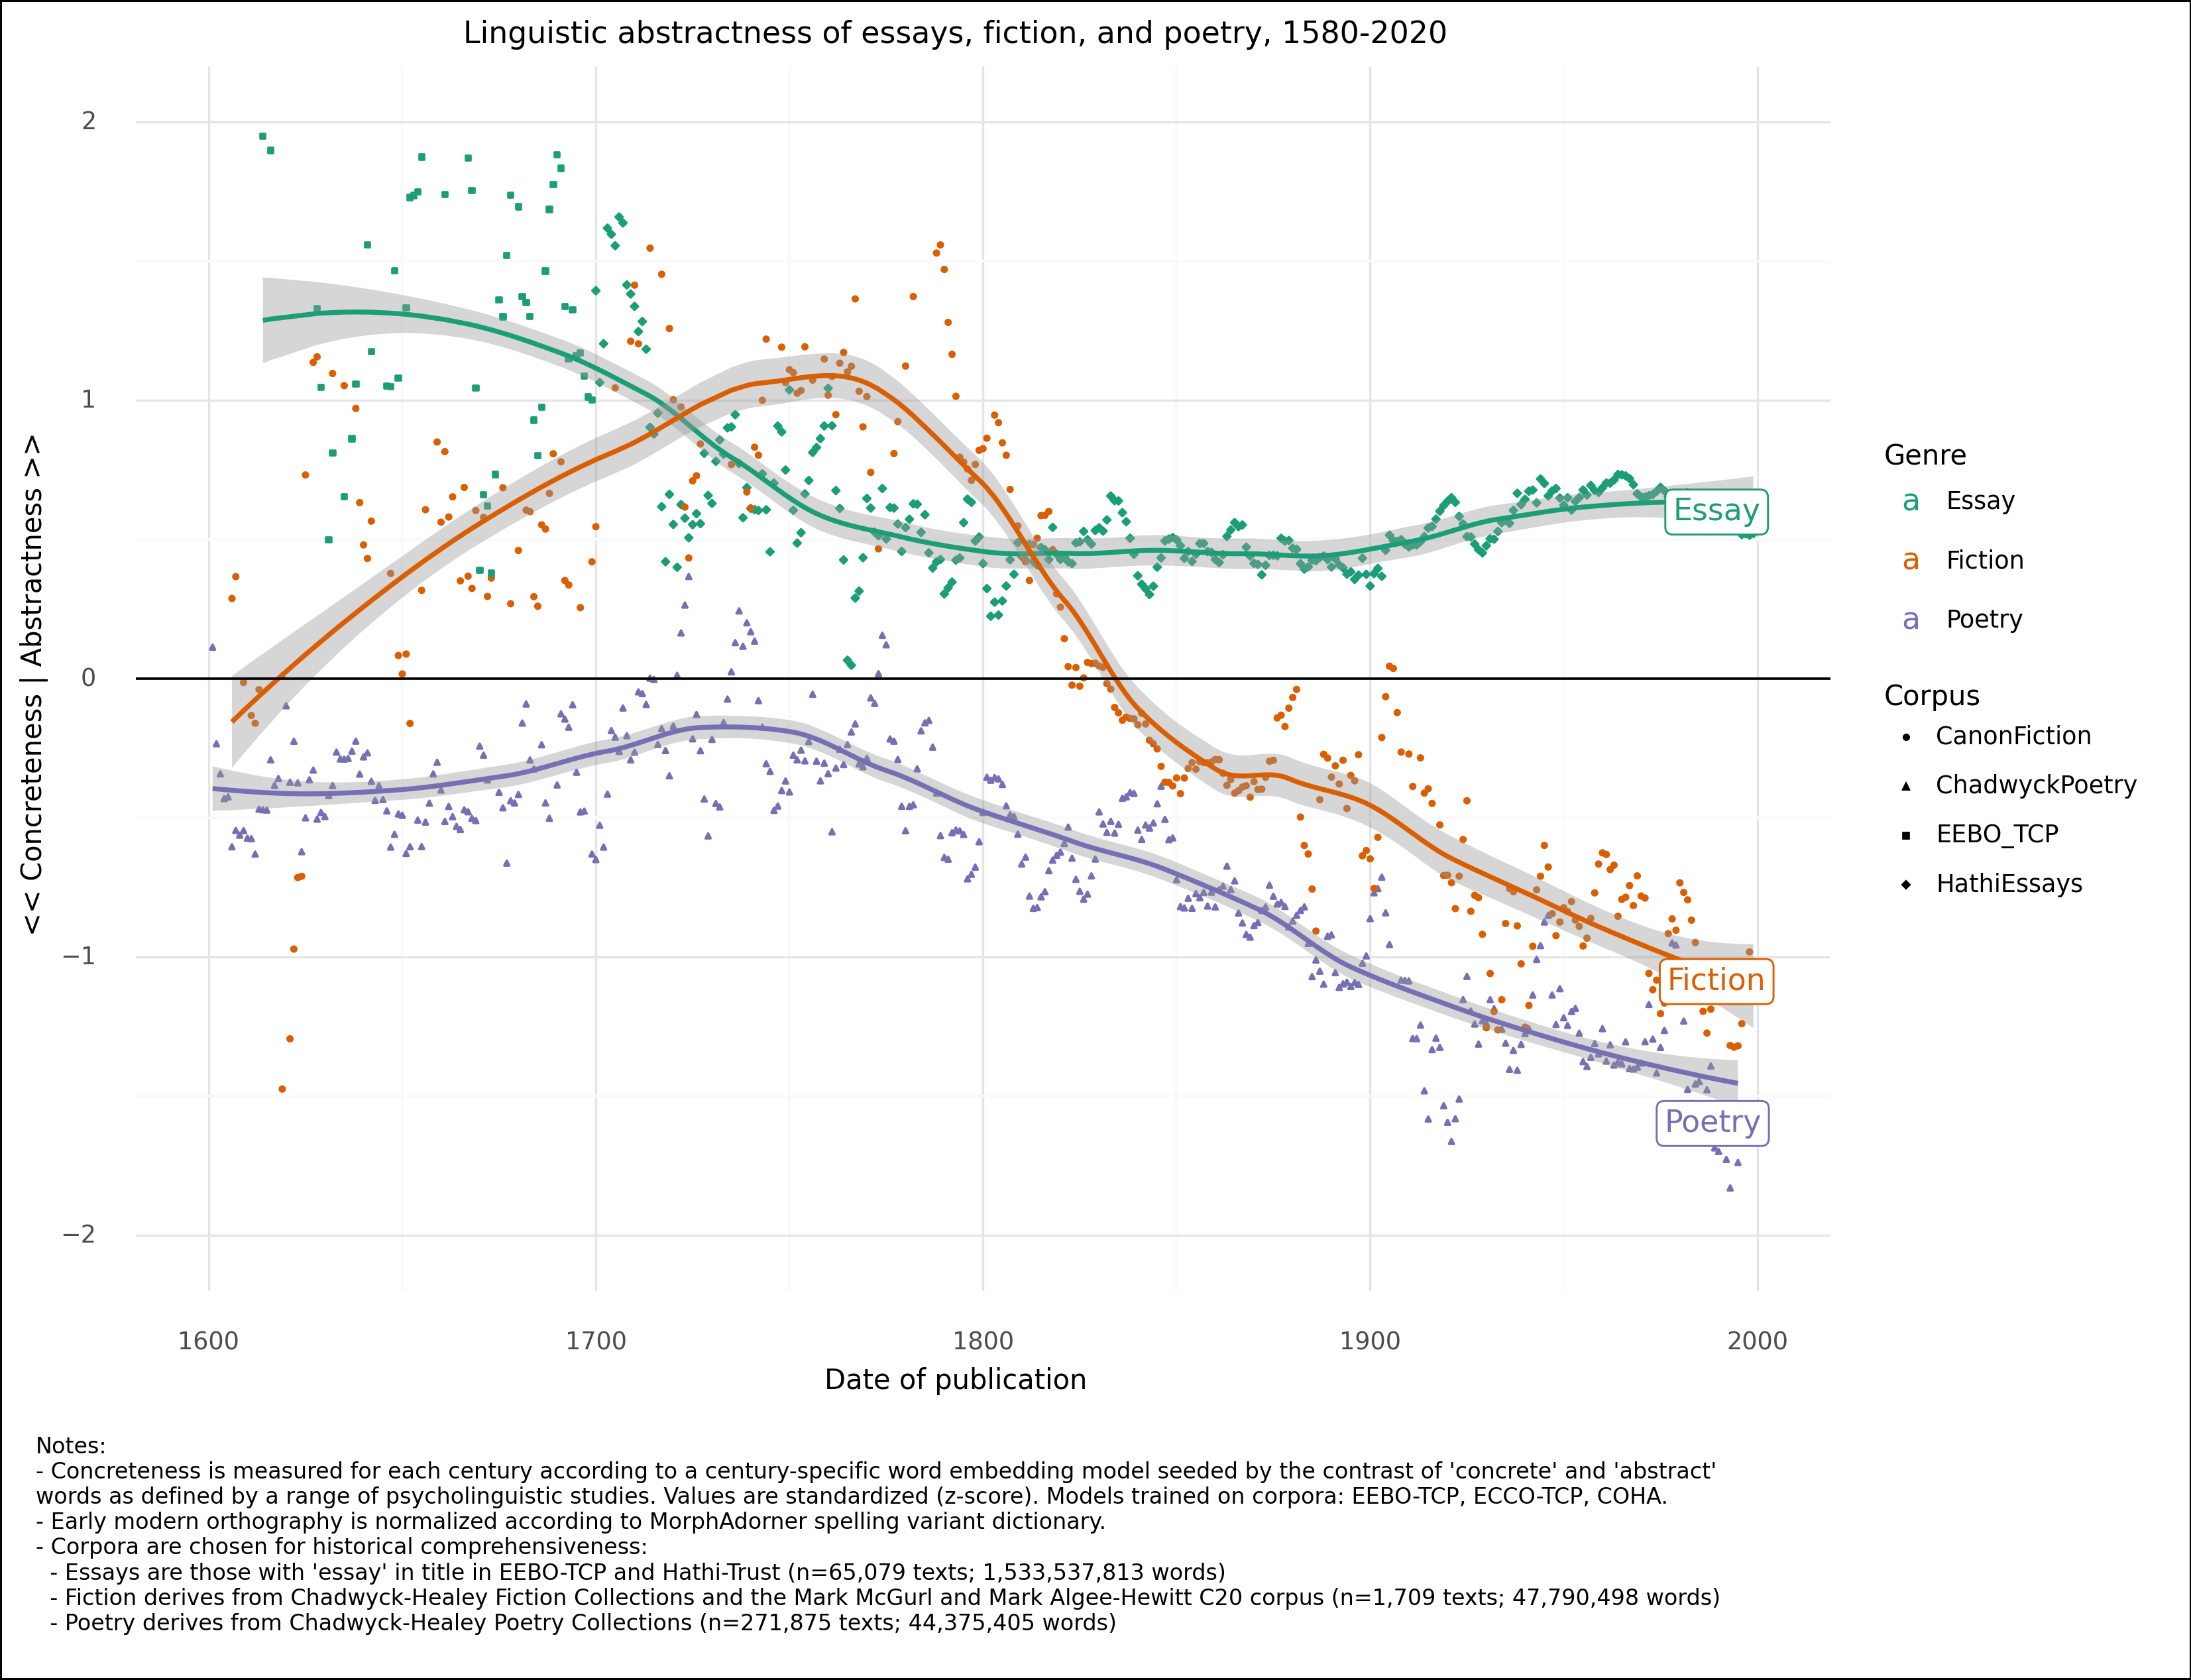

<ggplot: (732485578)>

In [50]:
p9.options.figure_size=11,8
fig = p9.ggplot(figdf, p9.aes(x='year', y='Abs-Conc.Median.dynamic',color='genre'))
# fig = p9.ggplot(figdf, p9.aes(x='year', y='Abs-Conc.Median.dynamic',color='genre',shape='corpus'))
# fig += p9.geom_point(p9.aes(size='num_words'))#,size=.5)
fig += p9.geom_point(p9.aes(shape='corpus'),size=.5)#, show_legend=False)#,size='num_words'))
fig += p9.geom_smooth(method='loess',span=.5)
fig += p9.ylim(-2,2)
# fig += p9.coord_flip()
# fig += p9.scale_x_reverse()
# fig += p9.scale_y_reverse(limits=[-2,2])
fig += p9.scale_size([.5,3])
fig += p9.theme_minimal()
fig += p9.theme(
    # axis_title=p9.element_text(weight='bold', size=8),
    plot_title=p9.element_text(size=11),
    axis_title=p9.element_text(size=10),
    legend_title=p9.element_text(size=10),
    caption=p9.element_text(
        size=8,
        ha='left',
        margin={'r':650, 't':25}
    ),
    # text=p9.element_text(color='white'),
    plot_background=p9.element_rect(fill='white'),
)
fig += p9.geom_hline(yintercept=0)

figdf=figdf.sort_values('year')
for genre in figdf.genre.unique():
    gdf=figdf[figdf.genre==genre]
    # data1=gdf.iloc[:20].groupby(['genre','corpus']).median().reset_index()
    data2=gdf.iloc[-20:].groupby(['genre','corpus']).median().reset_index()
    # fig += p9.geom_label(p9.aes(label='genre'), data=data1)
    fig += p9.geom_label(p9.aes(label='genre'), data=data2)
fig += p9.scale_color_brewer(palette=2, type='qual')

caption=f"""
Notes:
- Concreteness is measured for each century according to a century-specific word embedding model seeded by the contrast of 'concrete' and 'abstract'
words as defined by a range of psycholinguistic studies. Values are standardized (z-score). Models trained on corpora: EEBO-TCP, ECCO-TCP, COHA.
- Early modern orthography is normalized according to MorphAdorner spelling variant dictionary.
- Corpora are chosen for historical comprehensiveness:
  - Essays are those with 'essay' in title in EEBO-TCP and Hathi-Trust {genrestat["Essay"]}
  - Fiction derives from Chadwyck-Healey Fiction Collections and the Mark McGurl and Mark Algee-Hewitt C20 corpus {genrestat["Fiction"]}
  - Poetry derives from Chadwyck-Healey Poetry Collections {genrestat["Poetry"]}
"""


fig += p9.labs(
    title='Linguistic abstractness of essays, fiction, and poetry, 1580-2020',
    # title='Linguistic concreteness of essays, fiction, and poetry, 1580-2020',
    color='Genre',
    size='Num. words',
    shape='Corpus',
    y='<< Concreteness | Abstractness >>   ',
    # y='<< Abstractness | Concreteness >>  ',
    x='Date of publication',
    caption=caption
)
fig.save(os.path.join(PATH_FIGS,'fig.concreteness.bigdata.2022.v3.png'))
fig